In [7]:
from Bio import Phylo
from Bio import SeqIO
import numpy as np
import math
import random
from numpy.random import default_rng
rng = default_rng() # random number generator
import textwrap

In [2]:
# set up parameters 
u0 = 1e-6 # mutation rate of chromosome
u1 = 1e-4 # mutation rate of gene locus
a = 0.02 # gene gain rate 
b = 0.02 # gene loss rate 
n = 10 # number of initial copies, must be greater than 5 to push the program to run
l = 100 # length of the gene sequence (AA)

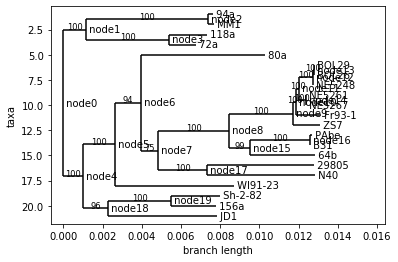

In [3]:
tree = Phylo.read("Bb_genome_reduced.tree", "newick") # genome tree of B.burgdorferi
internal_clades = tree.get_nonterminals()
for i in range(len(internal_clades)):
    internal_clades[i].name = "node%i" %i # name internal nodes
Phylo.draw(tree)

In [150]:
def all_parents(tree):
    parents = {}
    for clade in tree.find_clades(order="level"):
        for child in clade:
            parents[child.name] = clade
    return parents

In [57]:
def random_protein_sequence(l, n):
    AA = ('A','R','N','D','C','E','Q','G','H','I','L','K','M','F','P','S','T','W','Y','V')
    copies = {}
    for i in range(n):
        seq_id = 'gene%i' %i
        copies[seq_id] = ''.join(np.random.choice(AA) for _ in range(l))
    return copies 

In [212]:
def mutation(genes, prob):
    for name, seq in genes.items(): # for each gene,
        n_mut =  rng.poisson(prob) # determine how many sites to be mutated
        if n_mut > 0:
            seq = list(seq) # convert string to list in order to subscribe
            sites_mut = random.sample(range(l), n_mut) # choose the sites to mutate
            for site in sites_mut: # mutate the sites one by one
                AA = ['A','R','N','D','C','E','Q','G','H','I','L','K','M','F','P','S','T','W','Y','V']
                ori = seq[site]
                AA.remove(ori) # remove the original letter to avoid sampling the same letter
                seq[site] = np.random.choice(AA) # random substitution
            genes[name] = ''.join(seq)
    return(genes) 

In [147]:
def duplication(genes, prob):
    n_gain = rng.poisson(prob) # determine how many genes to be duplicated
    if n_gain > 0:
        gene_gain = random.sample(list(genes), n_gain) # choose the genes to duplicate 
        for gene in gene_gain:
            i = 1
            name = '%s_%i' %(gene, i)
            while name in genes: # check if name is already there
                i = i + 1 
                name = '%s_%i' %(gene, i) # create a new name
            genes[name] = genes[gene] # add new copy to the dict
    return(genes)

In [214]:
def deletion(genes, prob):
    n_loss = rng.poisson(prob) # determine how many genes to be deleted
    if n_loss > 0:
        gene_loss = random.sample(list(genes), n_loss) # choose the genes to delete
        for item in gene_loss: # remove items from the dict one by one
            genes.pop(item)
    return(genes)

In [149]:
def write_fasta(dictionary, filename):
    with open(filename, "w") as outfile:
        for key, value in dictionary.items():
            outfile.write(">" + key + "\n")
            outfile.write("\n".join(textwrap.wrap(value, 60)))
            outfile.write("\n")

In [217]:
### Main body of the simulator ###
# initiation 
root = random_protein_sequence(l, n)
tree_dic = {}
tree_dic['node0'] = root # a nesting dictionary

# tree_walking and evolution
allclades = list(tree.find_clades(order="level"))
parents = all_parents(tree)

for clade in allclades[1:]: # except the root 
    time = clade.branch_length/u0 # convert branch length to time
    p_mut = 1 - math.exp(-(u1*time)) # probability of mutation
    p_gain = (a/(a+b))*(1-math.exp(-((a+b)*time))) # probability of gain
    p_loss = 1 - p_gain # probability of loss
    
    parent = parents[clade.name].name # retrieve the name of the parent node
    genes = tree_dic[parent] # retrieve parent's gene set
    genes = mutation(genes, p_mut) 
    genes = duplication(genes, p_gain) 
    genes = deletion(genes, p_loss)
    tree_dic[clade.name] = genes # add new gene set to the dict
            
print("Simulation is done!")    

# extract terminal names and sequences
tips = [tip.name for tip in tree.get_terminals()]
seq_dic = {}
for taxon in tips:
    for name, seq in tree_dic[taxon].items():
        seq_dic["%s_%s" %(taxon, name)] = seq
    
# export simulated sequences to a fasta file
write_fasta(seq_dic, "bb_vls_sim.fas")
print("Success! File written") 


Simulation is done!
Success! File written
